In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - river-dl

In [2]:
# data from Simon's ~June 2022 river-dl run
river_dl = np.load("../../../Downloads/prepped_365_1.npz", allow_pickle = True)

# Subsetting data to
#    last year of data, (last batch of 455)
#    180-day sequences (second half of the water? year)
#    first 7 input vars (redundant now)
x = torch.from_numpy(river_dl['x_trn']).float()[-455:, -180:, :7]
y = torch.from_numpy(river_dl['y_obs_trn']).float()[-455:, -180:]

adj_matrix = river_dl['dist_matrix']
batch_size = adj_matrix.shape[0]

x.shape, y.shape, adj_matrix.shape

(torch.Size([455, 180, 7]), torch.Size([455, 180, 1]), (455, 455))

# Define RGCN v1

In [3]:
## RGCN - This version follows the published version of the RGCN by Jia et al. (2020)
# https://doi.org/10.1137/1.9781611976700.69
class RGCN_v1(nn.Module):
    # Built off of https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091
    def __init__(self, input_dim, hidden_dim, adj_matrix, recur_dropout=0, dropout=0, return_states=False, device='cpu'):
        """
        @param input_dim: [int] number input feature
        @param hidden_dim: [int] hidden size
        @param adj_matrix: Distance matrix for graph convolution
        @param recur_dropout: [float] fraction of the units to drop from the cell update vector. See: https://arxiv.org/abs/1603.05118
        @param dropout: [float] fraction of the units to drop from the input
        @param return_states: [bool] If true, returns h and c states as well as predictions
        """
        super().__init__()

        # New stuff
        self.A = torch.from_numpy(adj_matrix).float().to(device)  # provided at initialization
        # parameters for mapping graph/spatial data
        self.weight_q = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.bias_q = nn.Parameter(torch.Tensor(hidden_dim))

        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()

        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)

        self.dense = nn.Linear(hidden_dim, 1)
        self.return_states = return_states

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]),  # input
                torch.sigmoid(gates[:, HS:HS * 2]),  # forget
                torch.tanh(gates[:, HS * 2:HS * 3]),
                torch.sigmoid(gates[:, HS * 3:]),  # output
            )
            q_t = torch.tanh(h_t @ self.weight_q + self.bias_q)
            c_t = f_t * (c_t + self.A @ q_t) + i_t * self.recur_dropout(g_t)  # note: self.A @ q_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(1))
        hidden_seq = torch.cat(hidden_seq, dim=1)
        out = self.dense(hidden_seq)
        if self.return_states:
            return out, (h_t, c_t)
        else:
            return out
        
def rmse_masked(y_true, y_pred):
    num_y_true = torch.count_nonzero(~torch.isnan(y_true))
    if num_y_true > 0:
        zero_or_error = torch.where(
            torch.isnan(y_true), torch.zeros_like(y_true), y_pred - y_true
        )
        sum_squared_errors = torch.sum(torch.square(zero_or_error))
        rmse_loss = torch.sqrt(sum_squared_errors / num_y_true)
    else:
        rmse_loss = 0.0
    return rmse_loss

In [4]:
model = RGCN_v1(7, 20, adj_matrix)

In [5]:
loss_fn = rmse_masked
optimizer = torch.optim.Adam(model.parameters())

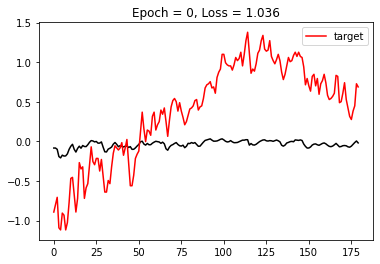

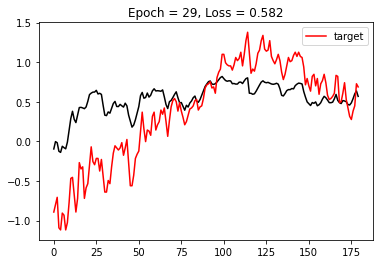

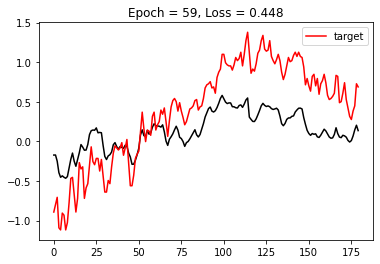

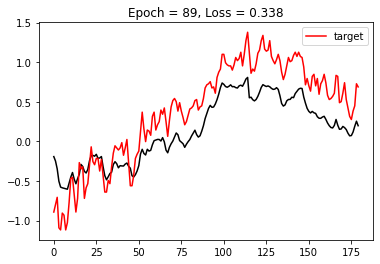

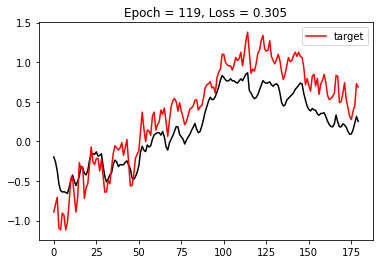

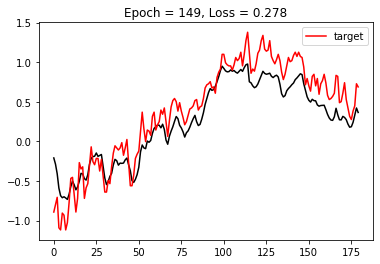

In [6]:
epochs = 150

for i in range(epochs):
    out = model(x)
    loss = loss_fn(y, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % int(epochs/5) == 0 or i == 0:
        plt.plot(out.detach()[1], color = 'black')
        plt.plot(y[-455:][1], color = 'red', label = 'target')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.pause(0.001);

# Run expected gradients twice for 200 samples and see if there's (a) convergence within a run and (b) converge to the same attributions

In [7]:
%%time
K = 200
temporal_focus = -1
spatial_focus = None

x = torch.from_numpy(river_dl['x_trn']).float()[:, -180:, :7]

n_series = river_dl['x_trn'].shape[0]
n_segs = adj_matrix.shape[0]
num_vars = x.shape[2]
seq_len = x.shape[1]

x_4D = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)

expected_gradiants_ls1 = torch.zeros([K, n_segs, seq_len, num_vars])

for k in range(K):
    # SAMPLE A RANDOM BASELINE INPUT/YEAR
    rand_year = np.random.choice(n_series//n_segs)
    baseline_x = x_4D[rand_year]
        
    # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
    scale = np.random.uniform()
    
    # SAME IG CALCULATION
    x_diff = x[-455:] - baseline_x
    curr_x = baseline_x + scale*x_diff
    curr_x.requires_grad = True
    model.zero_grad()
    y = model(curr_x)
    
    # GET GRADIENT
    if temporal_focus == None and spatial_focus == None:
        gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
    elif temporal_focus == None and spatial_focus != None:
        gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
    elif temporal_focus != None and spatial_focus == None:
        gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
    else:
        gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))
        
    if k == 0:
        expected_gradients = x_diff*gradients[0] * 1/K
    else:
        expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/K)
        
    expected_gradiants_ls1[k] = expected_gradients

Wall time: 1min 54s


In [8]:
%%time
K = 200
temporal_focus = -1
spatial_focus = None

x = torch.from_numpy(river_dl['x_trn']).float()[:, -180:, :7]

n_series = river_dl['x_trn'].shape[0]
n_segs = adj_matrix.shape[0]
num_vars = x.shape[2]
seq_len = x.shape[1]

x_4D = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)

expected_gradiants_ls2 = torch.zeros([K, n_segs, seq_len, num_vars])

for k in range(K):
    # SAMPLE A RANDOM BASELINE INPUT/YEAR
    rand_year = np.random.choice(n_series//n_segs)
    baseline_x = x_4D[rand_year]
        
    # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
    scale = np.random.uniform()
    
    # SAME IG CALCULATION
    x_diff = x[-455:] - baseline_x
    curr_x = baseline_x + scale*x_diff
    curr_x.requires_grad = True
    model.zero_grad()
    y = model(curr_x)
    
    # GET GRADIENT
    if temporal_focus == None and spatial_focus == None:
        gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
    elif temporal_focus == None and spatial_focus != None:
        gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
    elif temporal_focus != None and spatial_focus == None:
        gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
    else:
        gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))
        
    if k == 0:
        expected_gradients = x_diff*gradients[0] * 1/K
    else:
        expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/K)
        
    expected_gradiants_ls2[k] = expected_gradients

Wall time: 1min 55s


looking at  seg_tave_air


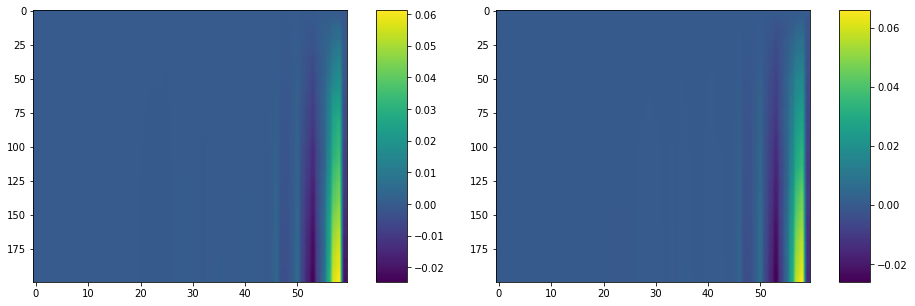

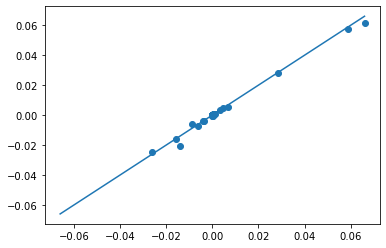

In [9]:
fig, ax = plt.subplots(1, 5, figsize = (15, 5), gridspec_kw={'width_ratios': [10, 1, 1, 10, 1]})

var = 3
print('looking at ', river_dl['x_vars'][var])

im1 = ax[0].imshow(expected_gradiants_ls1[:, 0, -60:, var], aspect = 'auto')
fig.colorbar(im1, ax[1])

ax[2].set_visible(False)

im2 = ax[3].imshow(expected_gradiants_ls2[:, 0, -60:, var], aspect = 'auto')
fig.colorbar(im2, ax[4])

plt.pause(0.001)

plt.scatter(expected_gradiants_ls2[-1, 0, :, var],
            expected_gradiants_ls1[-1, 0, :, var])
plt.plot([-1*max(np.abs(expected_gradiants_ls2[-1, 0, :, var])),
          max(np.abs(expected_gradiants_ls2[-1, 0, :, var]))],
         [-1*max(np.abs(expected_gradiants_ls2[-1, 0, :, var])),
          max(np.abs(expected_gradiants_ls2[-1, 0, :, var]))]);

**There does appear to be convergence within and across runs**

# Defining expected gradients as a function and performing the same integrated gradients experiments

In [10]:
def expected_gradients(x, y, x_set, adj_matrix, model, n_samples, temporal_focus=None, spatial_focus=None):

    n_series = x_set.shape[0]
    n_segs = adj_matrix.shape[0]
    num_vars = x_set.shape[2]
    seq_len = x_set.shape[1]

    x_set_4D = x_set.reshape(n_series//n_segs,n_segs,seq_len,num_vars)

    for k in range(n_samples):
        # SAMPLE A RANDOM BASELINE INPUT/YEAR
        rand_year = np.random.choice(n_series//n_segs)
        baseline_x = x_set_4D[rand_year]

        # SAMPLE A RANDOM SCALE ALONG THE DIFFERENCE
        scale = np.random.uniform()

        # SAME IG CALCULATION
        x_diff = x - baseline_x
        curr_x = baseline_x + scale*x_diff
        if curr_x.requires_grad == False:
            curr_x.requires_grad = True
        model.zero_grad()
        y = model(curr_x)

        # GET GRADIENT
        if temporal_focus == None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, :, :], curr_x, torch.ones_like(y[:, :, :]))
        elif temporal_focus == None and spatial_focus != None:
            gradients = torch.autograd.grad(y[spatial_focus, :, :], curr_x, torch.ones_like(y[spatial_focus, :, :]))
        elif temporal_focus != None and spatial_focus == None:
            gradients = torch.autograd.grad(y[:, temporal_focus, :], curr_x, torch.ones_like(y[:, temporal_focus, :]))
        else:
            gradients = torch.autograd.grad(y[spatial_focus, temporal_focus, :], curr_x, torch.ones_like(y[spatial_focus, temporal_focus, :]))

        if k == 0:
            expected_gradients = x_diff*gradients[0] * 1/K
        else:
            expected_gradients = expected_gradients + ((x_diff*gradients[0]) * 1/K)
    return(expected_gradients)

In [11]:
%%time
EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=None, spatial_focus=None)

Wall time: 1min 54s


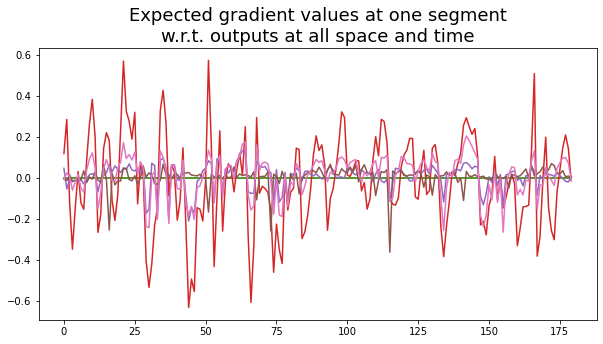

In [12]:
EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=None, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(EG_vals[0, :, i])
plt.title('Expected gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

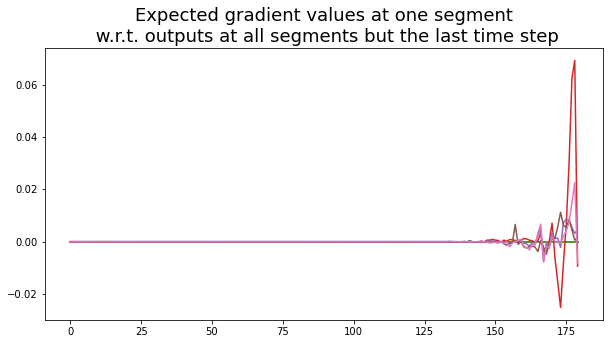

In [13]:
EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=-1, spatial_focus=None)

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(EG_vals[0, :, i])
plt.title('Expected gradient values at one segment\n w.r.t. outputs at all segments but the last time step',
          fontsize = 18);

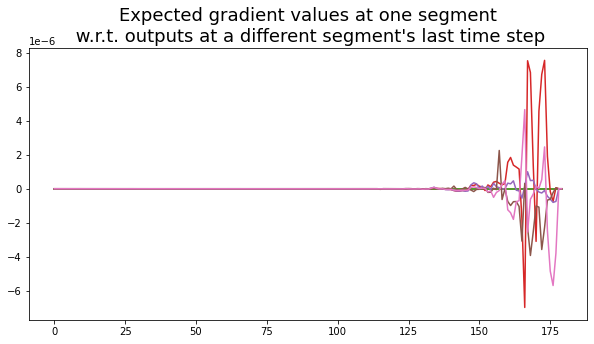

In [14]:
EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=-1, spatial_focus=-1)

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(EG_vals[0, :, i])
plt.title("Expected gradient values at one segment\n w.r.t. outputs at a different segment's last time step",
          fontsize = 18);

# Apply XAI and visualize - can we trust IG temporally?

When looking at what's important for the last time step's prediction, it appears that anything before the last 45 values don't matter. Let's do an experiment where we scramble those supposedly irrelevant values and see how it impacts predictions

In [15]:
EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=-1, spatial_focus=None)

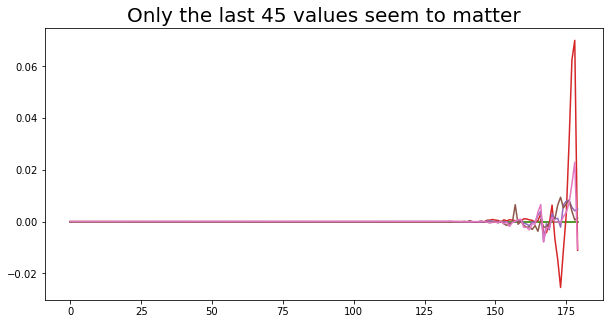

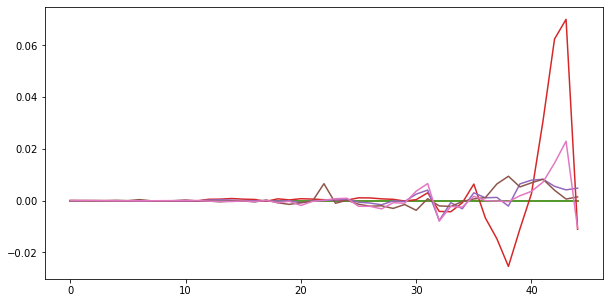

In [16]:
plt.figure(figsize = (10, 5))
plt.plot(EG_vals[0, :, :])
plt.title('Only the last 45 values seem to matter', fontsize = 20)
plt.pause(0.001)
plt.figure(figsize = (10, 5))
plt.plot(EG_vals[0, -45:, :]);

In [17]:
def compare_temporally_altered(first_n_days):
    y_hat_original = model(x[-455:])

    # replace first n days with random values
    # and see how results change
    x_hypothesis = x[-455:].detach().clone()
    x_hypothesis[:, :first_n_days] = torch.rand_like(x[-455:, :first_n_days])
    y_hat_hypothesis = model(x_hypothesis)

    fig, ax = plt.subplots(3, 2, figsize = (12, 9))

    ax[0,0].plot(x[0].detach(), color = 'black', alpha = 0.1)
    ax[0,0].set_ylim(-3, 5)
    ax[0,1].plot(x_hypothesis[0], color = 'black', alpha = 0.1)
    ax[0,1].set_ylim(-3, 5)
    ax[1,0].plot(y_hat_original[0].detach())
    ax[1,0].set_ylim(-1.5, 1.5)
    ax[1,1].plot(y_hat_hypothesis[0].detach())
    ax[1,1].set_ylim(-1.5, 1.5)
    ax[2,0].plot(y_hat_original[0, :].detach())
    ax[2,0].plot(y_hat_hypothesis[0, :].detach())
    ax[2,1].plot(y_hat_original[0, -60:].detach())
    ax[2,1].plot(y_hat_hypothesis[0, -60:].detach());

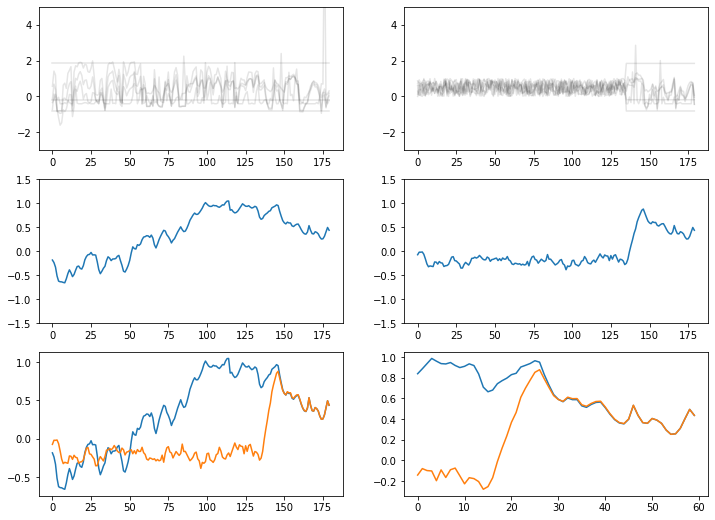

In [18]:
compare_temporally_altered(180-45)

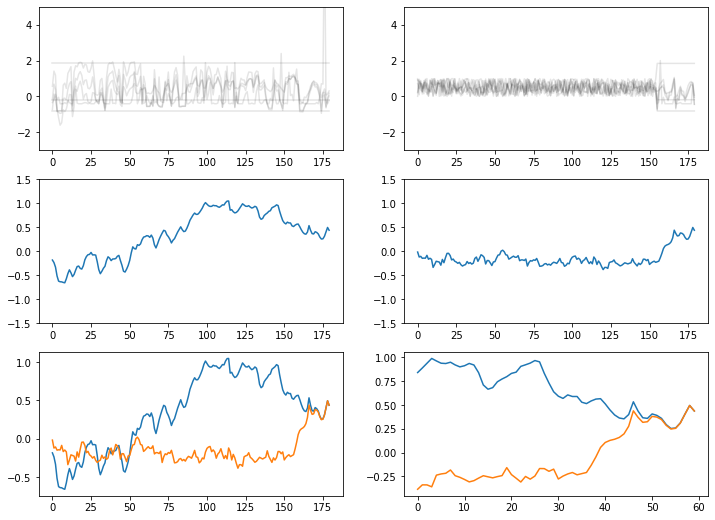

In [19]:
compare_temporally_altered(180-25)

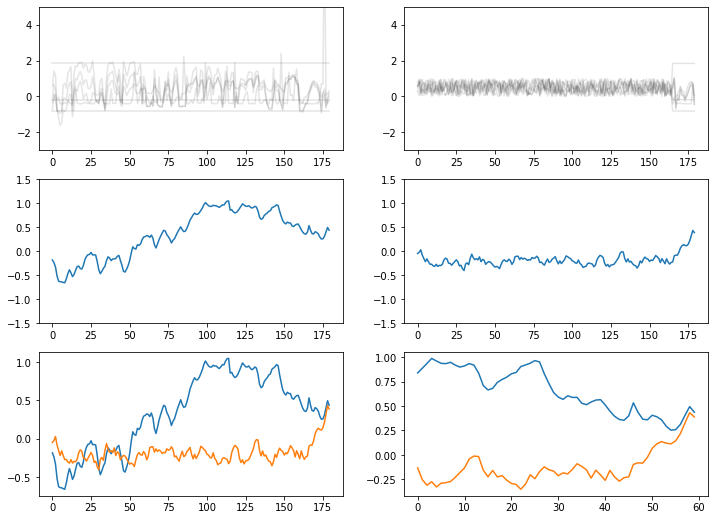

In [20]:
compare_temporally_altered(180-15)

The evidence appears to suggest that we can trust how IG explains importance temporally

# Apply XAI and visualize - can we trust IG spatially?

Similar experiment to the above, but seeing if we can trust what neighboring streams are identified as important

In [21]:
def compare_spatially_altered(seg_of_interest, important_segments, unimportant_segments):
    y_hat_original = model(x[-455:])

    x_hypothesis1 = x[-455:].detach().clone()
    for s in important_segments:
        x_hypothesis1[s] = torch.rand_like(x[-455:][s])
    y_hat_hypothesis1 = model(x_hypothesis1)
    
    x_hypothesis2 = x[-455:].detach().clone()
    for s in unimportant_segments:
        x_hypothesis2[s] = torch.rand_like(x[-455:][s])
    y_hat_hypothesis2 = model(x_hypothesis2)

    fig, ax = plt.subplots(5, figsize = (10, 30))

    for seg in important_segments:
        ax[0].plot(x[seg].detach(), color = 'black', alpha = 0.05)
        ax[1].plot(x_hypothesis1[seg], color = 'black', alpha = 0.1)
        ax[1].set_title('Changed segment variable values | important')
        
    for seg in unimportant_segments:
        ax[0].plot(x[seg].detach(), color = 'black', alpha = 0.05)
        ax[0].set_title('Unchanged segment variable')
        ax[2].plot(x_hypothesis2[seg], color = 'black', alpha = 0.1)
        ax[2].set_title('Changed segment variable values | unimportant')
    
    ax[3].set_title('Predictions under different scenarios')
    ax[3].plot(y_hat_original[seg_of_interest, :].detach(),
               label = 'Original')
    ax[3].plot(y_hat_hypothesis1[seg_of_interest, :].detach(),
               label = 'Important segments changed',
               linestyle = '--')
    ax[3].plot(y_hat_hypothesis2[seg_of_interest, :].detach(),
               label = 'Unimportant segments changed',
               linestyle = '--')
    ax[3].legend()
    
    ax[4].set_title('Difference in predictions')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis1[seg_of_interest, :].detach(),
                 label = 'Important segments changed')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis2[seg_of_interest, :].detach(),
                 label = 'Unimportant segments changed')
    ax[4].legend()

In [22]:
spatial_focus = np.random.choice(455)

EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=-1, spatial_focus=spatial_focus)

most_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals.detach().numpy()), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals.detach().numpy()), axis = 2), axis = 1))[-5:]

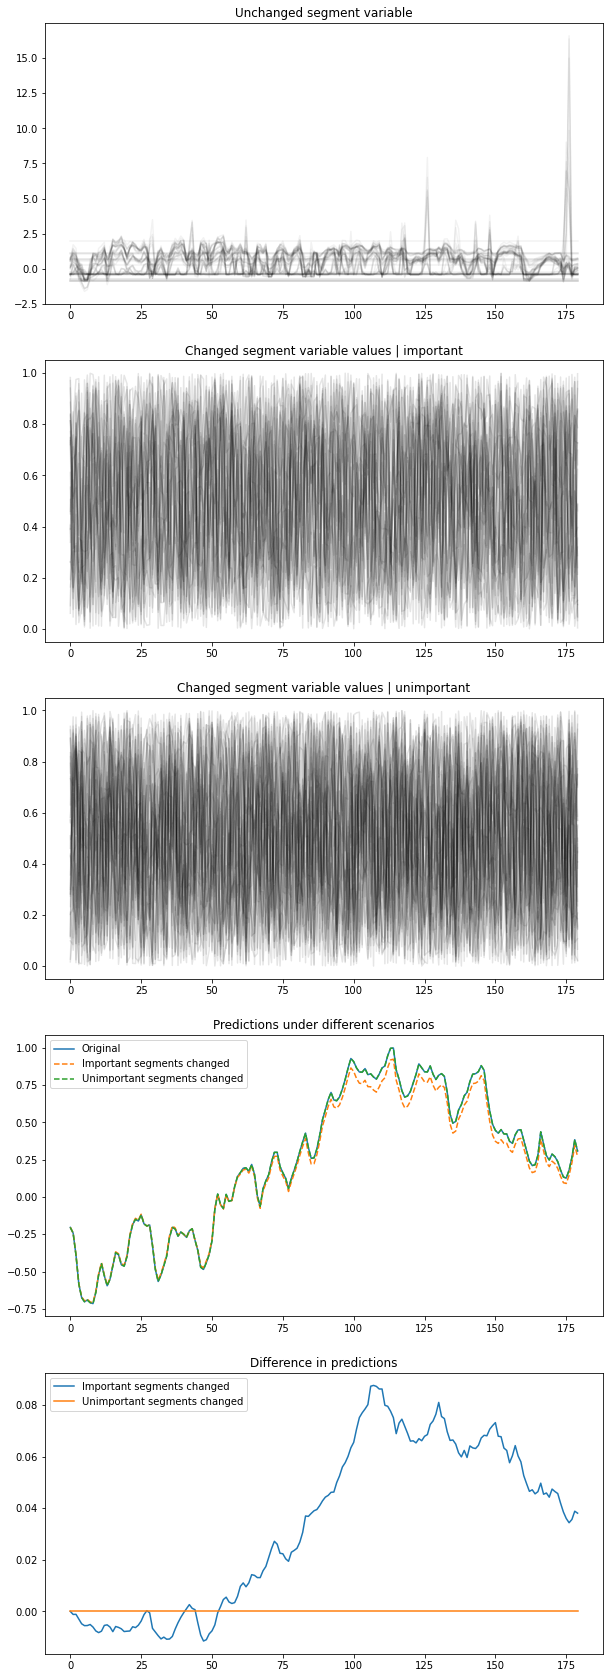

In [23]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

### A slightly more obvious difference in predictions

Spatial information doesn't seem to play a huge role, so hand-picking a more sensitive segment helps show the difference

In [24]:
spatial_focus = -1

EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=-1, spatial_focus=spatial_focus)

most_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals.detach().numpy()), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(EG_vals.detach().numpy()), axis = 2), axis = 1))[-5:]

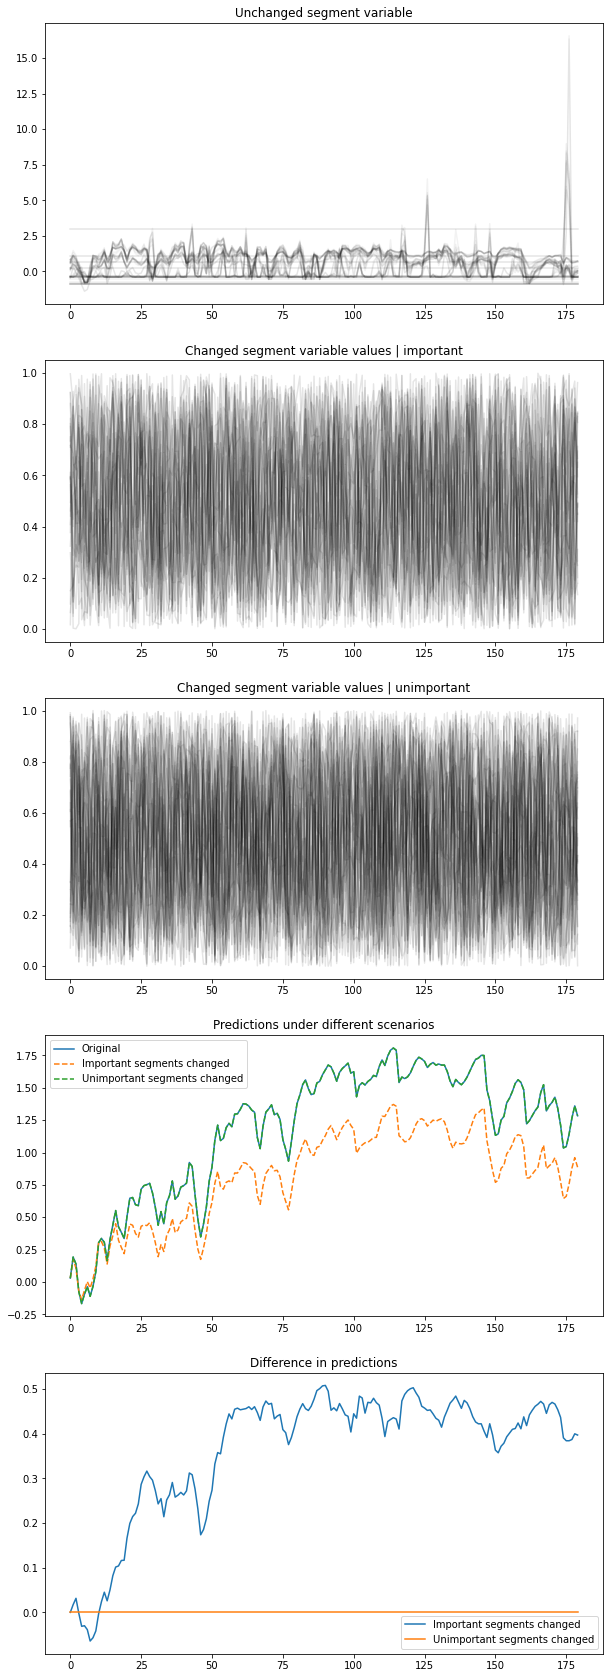

In [25]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

The evidence appears to suggest that we can trust how IG explains importance spatially

# Can we trust the feature importance?

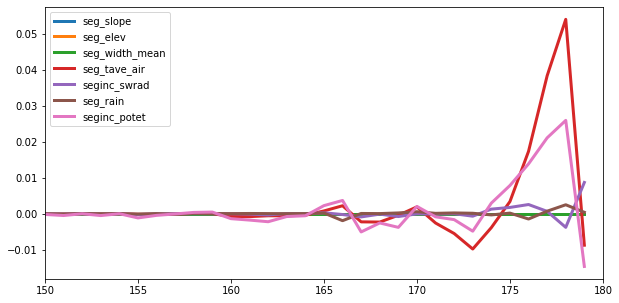

In [26]:
spatial_focus = 1 # has lots of observations

EG_vals = expected_gradients(x[-455:, -180:, :7], y[-455:, -180:], x[:, -180:, :7], adj_matrix, model,
                             200, temporal_focus=-1, spatial_focus=spatial_focus)

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(EG_vals.detach().numpy()[spatial_focus, :, i], label = river_dl['x_vars'][i], linewidth = 3)
plt.xlim(150, 180)
plt.legend(loc = 'upper left');

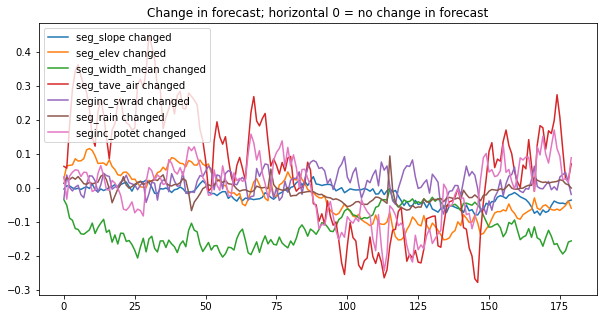

In [27]:
original_y_hat = model(x[-455:, -180:, :7])

rmse_ls = []
plt.figure(figsize = (10, 5))

for i in range(7):
    x_hypothesis = x[-455:, -180:, :7].detach().clone()
    x_hypothesis[1, :, i] = torch.rand_like(x_hypothesis[1, :, i]) # change the variables
    
    y_hypothesis = model(x_hypothesis)
    
    plt.plot(y_hypothesis[1].detach() - original_y_hat[1].detach(), # view difference in forecast
             label = river_dl['x_vars'][i] + ' changed')
    plt.title('Change in forecast; horizontal 0 = no change in forecast')
    
plt.legend(loc = 'upper left');

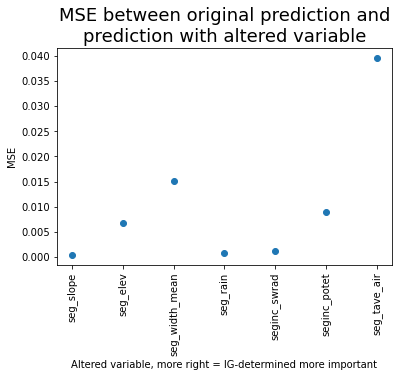

In [28]:
ordered_importance_of_vars = np.argsort(np.sum(np.abs(EG_vals[1].detach().numpy()), axis = 0))

mse_ls = []
for var in ordered_importance_of_vars:
    x_hypothesis = x[-455:, -180:, :7].detach().clone()
    x_hypothesis[1, :, var] = torch.rand_like(x_hypothesis[1, :, var])
    y_hypothesis = model(x_hypothesis)
    mse = torch.mean((y_hypothesis[1].detach() - original_y_hat[1].detach())**2).item()
    mse_ls.append(mse)
    
plt.scatter(range(len(mse_ls)), mse_ls)
plt.xticks(range(len(mse_ls)), labels = river_dl['x_vars'][ordered_importance_of_vars], rotation = 90)
plt.title('MSE between original prediction and\nprediction with altered variable', fontsize = 18)
plt.ylabel('MSE')
plt.xlabel('Altered variable, more right = IG-determined more important');

In agreement for dynamic variables. EG isn't really sampling different static variables with our set up, not well-equipped to determine their importance; to sample different static variables we would need to sample between segments which would allow unrealistic baselines (e.g., a very high elevation segment being directly downstream of a very low elevation segment)